In [1]:
import os
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [ ]:
# Load data and confirm shapes

d = np.load("data/dataset_splits.npz")
print("Keys:", d.files)

X_train = d["X_train"]
X_test  = d["X_test"]
y_train = d["y_train"].ravel()
y_test  = d["y_test"].ravel()

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

Keys: ['X_train', 'X_test', 'y_train', 'y_test']
X_train: (1254, 1000) X_test: (314, 1000)
y_train: (1254,) y_test: (314,)


In [3]:
# Preprocessing functions (SNV + SG 1st derivative)

def snv(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Standard Normal Variate per spectrum (row-wise)."""
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    return (X - mu) / (sd + eps)

def sg_first_derivative(X: np.ndarray, window_length: int = 11, polyorder: int = 2) -> np.ndarray:
    """Savitzky–Golay 1st derivative along wavelength axis."""
    if window_length % 2 == 0:
        window_length += 1
    return savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=1, axis=1)

def preprocess(X: np.ndarray) -> np.ndarray:
    """Strategy: SNV + SG 1st derivative."""
    return sg_first_derivative(snv(X), window_length=11, polyorder=2)

X_train_pp = preprocess(X_train)
X_test_pp  = preprocess(X_test)

print("X_train_pp:", X_train_pp.shape, "X_test_pp:", X_test_pp.shape)

X_train_pp: (1254, 1000) X_test_pp: (314, 1000)


In [4]:
#Train SVR (RBF) with CV tuning (train only)

seed = 42

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

cv = KFold(n_splits=10, shuffle=True, random_state=seed)

param_grid = {
    "svr__C": [1, 10, 50, 100],
    "svr__gamma": ["scale", 0.01, 0.005, 0.001],
    "svr__epsilon": [0.01, 0.05, 0.1],
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_pp, y_train)

best = grid.best_estimator_
print("Best params:", grid.best_params_)
print("CV best R2:", grid.best_score_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best params: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 0.001}
CV best R2: 0.6866618078029953


In [5]:
# Predict train + test

pred_train = best.predict(X_train_pp).reshape(-1).astype(np.float64)
pred_test  = best.predict(X_test_pp).reshape(-1).astype(np.float64)

print("pred_train shape:", pred_train.shape)  # (1254,)
print("pred_test shape :", pred_test.shape)   # (314,)

pred_train shape: (1254,)
pred_test shape : (314,)


In [6]:
# Metrics: R², RMSE, Bias, RPD (test + train)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def bias(y_true, y_pred):
    return float(np.mean(y_pred - y_true))

def rpd(y_true, y_pred):
    # RPD = SD(observed) / RMSE
    return float(np.std(y_true, ddof=1) / rmse(y_true, y_pred))

def metrics(y_true, y_pred):
    return {
        "R2": float(r2_score(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "Bias": bias(y_true, y_pred),
        "RPD": rpd(y_true, y_pred),
    }

m_train = metrics(y_train, pred_train)
m_test  = metrics(y_test, pred_test)

print("TRAIN metrics:", m_train)
print("TEST  metrics:", m_test)

TRAIN metrics: {'R2': 0.9095712560798818, 'RMSE': 4.255250564659145, 'Bias': -0.518929394457357, 'RPD': 3.3267486057909754}
TEST  metrics: {'R2': 0.7558037469881265, 'RMSE': 7.6489050170051565, 'Bias': -0.8694684926532744, 'RPD': 2.0268572249559553}


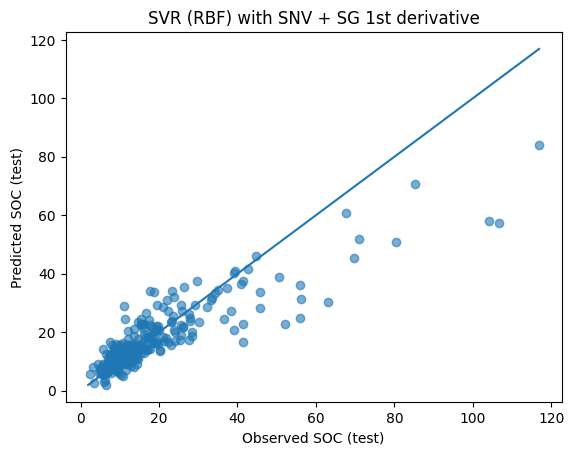

In [7]:
# Scatter plot of observed vs predicted (test)

plt.figure()
plt.scatter(y_test, pred_test, alpha=0.6)
mn = min(y_test.min(), pred_test.min())
mx = max(y_test.max(), pred_test.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observed SOC (test)")
plt.ylabel("Predicted SOC (test)")
plt.title("SVR (RBF) with SNV + SG 1st derivative")
plt.show()

In [8]:
# Create output directory

os.makedirs("data/predictions", exist_ok=True)

# Save predictions
np.savez_compressed(
    "data/predictions/svr_snv_sg1_preds.npz",
    pred_train=pred_train,
    pred_test=pred_test
)

# Save preprocessed spectra
np.savez_compressed(
    "data/predictions/snv_sg1_preprocessed_spectra.npz",
    X_train_pp=X_train_pp,
    X_test_pp=X_test_pp
)

print("Saved:")
print(" - data/predictions/svr_snv_sg1_preds.npz")
print(" - data/predictions/snv_sg1_preprocessed_spectra.npz")

Saved:
 - data/predictions/svr_snv_sg1_preds.npz
 - data/predictions/snv_sg1_preprocessed_spectra.npz


In [9]:
# Verify saved files

a = np.load("data/predictions/svr_snv_sg1_preds.npz")
b = np.load("data/predictions/snv_sg1_preprocessed_spectra.npz")

print("Saved pred shapes:", a["pred_train"].shape, a["pred_test"].shape)
print("Saved X_pp shapes:", b["X_train_pp"].shape, b["X_test_pp"].shape)

Saved pred shapes: (1254,) (314,)
Saved X_pp shapes: (1254, 1000) (314, 1000)
